# Dependencies and global options

In [1]:
#%reset
import glob
import os
import pandas as pd
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import types
import warnings
import itertools

In [2]:
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None

## (Extra) Dependencies for BoW Model:

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import string
from spacy.en import English
import spacy

## (Extra) Dependencies for text models:

In [4]:
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import  confusion_matrix
import mord as m
from wordcloud import WordCloud
import random

## NLP functions

In [5]:
parser = English()
nlp = spacy.load('en')

# Querying databases and importing data

First I import all their data as a dictionary of datasets from which I will extract the features for different models. The files are all in the dicrectory ``/raw_data``: 

In [6]:
path =r'raw_data' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
databases = {}
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0,low_memory=False)
    databases[re.sub(r'\W.*','',re.sub(r'.*/', '', file_))] = df

An instance of this data (an item) is a business objective, and the model will try to predict whether the objective will be completed or not by extracting various types of features from the natural language description of the objective and the non-text data associated with it in the CrossLead database. The dataset starts with a unique identifyier for the objective, called ```_id```

In [7]:
item_id = databases['triangleLayerItems']._id
layer_id = databases['triangleLayerItems'].triangleLayerId
data = pd.concat([item_id,layer_id],axis=1)

## Building target variable

The target variable will be user updated 'percentage complete', which is done by extracting from the status update list for each objective the last instance of percentage complete:

In [8]:
databases['triangleLayerItems'].statuses[5]

'[{"createdAt":{"$date":"2015-06-11T17:14:26.220Z"},"updatedAt":{"$date":"2015-06-11T17:14:26.220Z"},"percent":0,"color":2,"type":1},{"createdAt":{"$date":"2015-06-11T17:14:26.220Z"},"updatedAt":{"$date":"2015-06-11T17:14:31.015Z"},"percent":0,"color":1,"type":1},{"createdAt":{"$date":"2015-06-11T17:14:26.220Z"},"updatedAt":{"$date":"2015-07-16T18:43:26.024Z"},"percent":0,"color":2,"type":1},{"createdAt":{"$date":"2015-06-11T17:14:26.220Z"},"updatedAt":{"$date":"2015-07-17T20:18:40.201Z"},"percent":0,"color":2,"type":1},{"updatedAt":{"$date":"2015-10-01T19:18:03.455Z"},"percent":50,"color":1,"type":1,"id":{"$oid":"560d86eb7a9c381622ea7be6"}}]'

In [9]:
data['fin_status'] = databases['triangleLayerItems'].statuses.str.replace(r'.*"percent":', '').str.replace(r',.*','')
data['fin_status'] = pd.to_numeric(data['fin_status'],errors='coerce')

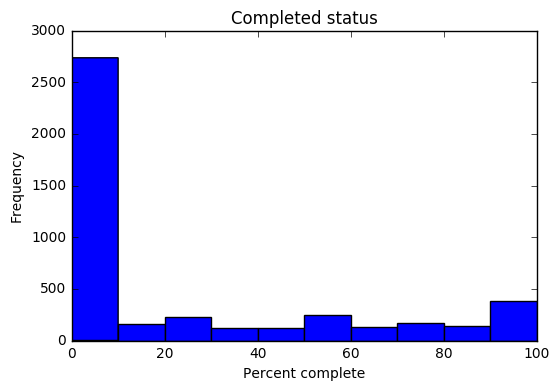

In [10]:
#Visualization of target variable:
plt.hist(data['fin_status'].dropna(),color='blue',range=(0, 100))
plt.title("Completed status")
plt.xlabel("Percent complete")
plt.ylabel("Frequency")
plt.show()

In [11]:
#Plus a large number of missing values:
data['fin_status'].isnull().sum()

2753

I will bin the target variable into four classes: NA's, Zeroes, (0,50], and (50-100]:

In [12]:
data.loc[data.loc[:,'fin_status'].isnull()==True,'completed'] = int(1)
data.loc[(data.loc[:,'fin_status']==0),'completed'] = 2
data.loc[(data.loc[:,'fin_status']>0) & (data.loc[:,'fin_status']<=50),'completed'] = int(3)
data.loc[(data.loc[:,'fin_status']>50),'completed'] = int(4)

Also, get rid of the pesky float type for 'completed'

In [13]:
data.completed = data.completed.astype(int)

In [14]:
data.completed.value_counts()

1    2753
2    2589
3    978 
4    865 
Name: completed, dtype: int64

## Getting text variable

In [15]:
data['item_name'] = databases['triangleLayerItems'].name

In [16]:
data.shape

(7185, 5)

## Getting dates to cut this (empty)

## Non-text features

First, I'm going to need the Layer Id of the objective:

### Number of 'watchers' and 'dependencies' an objective has:

In [17]:
data['watchers'] = [str(element).count('oid') for element in databases['triangleLayerItems'].watchers]
data.watchers.value_counts()

1    3919
0    1909
2    1065
3    201 
4    51  
5    25  
6    11  
7    4   
Name: watchers, dtype: int64

In [18]:
data['dependenciesN'] = [str(element).count('created') for element in databases['triangleLayerItems'].dependencies]
#data['dependenciesN'].value_counts()

### Labels

In [19]:
TLIlabels = sorted([item.lower() for item in databases['triangleLayers'].label.unique()])

In [20]:
TLImap = ['objective','other','other','strategy','principle','principle','initiative','initiative',
          'initiative','metric','metric','metric','metric','metric','mission','mission','objective',
          'objective','mission','value','vision','metric','value','other','other','other','objective',
          'principle','strategy','strategy','strategy','strategy','metric','metric','metric','other','other',
          'mission','value','vision','vision','vision','vision']

In [21]:
labelDict = {}
for label,value in zip(TLIlabels,TLImap):
    labelDict[label] = value

In [22]:
gen = data.iterrows()
labels = []
order = []
for index,row in gen:
    try:
        labels.append(databases['triangleLayers'].loc[(databases['triangleLayers']._id == row['triangleLayerId']),
                                                      'label'].item())
    except:
        labels.append(np.nan)
    try:
        order.append(databases['triangleLayers'].loc[(databases['triangleLayers']._id == row['triangleLayerId']),
                                                      'order'].item())
    except:
        order.append(np.nan)

In [23]:
data['labels'] = labels
data['labels'] = data['labels'].str.lower().map(labelDict)

In [24]:
data['labels'].value_counts()

initiative    2273
metric        1115
strategy      849 
objective     526 
other         521 
principle     97  
vision        40  
value         34  
mission       32  
Name: labels, dtype: int64

Make label even smaller by grouping the top level types (value,vision, mission, principle) into 'mvvp' label, and get NoLabel also as a category (empty string):

In [25]:
#make new dictionary:
labelDict_comp = {'initiative':'initiative', 'strategy':'strategy', 'objective':'objective', 
                  'vision':'pvvm', 'principle':'pvvm',
       'metric':'metric', 'other':'other', 'mission':'pvvm', 'value':'pvvm'}

In [26]:
data['labels'] = data['labels'].map(labelDict_comp)
data['labels'] = data['labels'].fillna('')
data['labels'].value_counts()

initiative    2273
              1698
metric        1115
strategy      849 
objective     526 
other         521 
pvvm          203 
Name: labels, dtype: int64

In [27]:
data['order'] = order
data['userId'] = databases['triangleLayerItems'].userId

Labels is a categorical variable, so I have to create dummies:

In [28]:
label_ranks = pd.get_dummies(data['labels'].astype('category').values, prefix='label')
label_ranks.columns

Index(['label_', 'label_initiative', 'label_metric', 'label_objective',
       'label_other', 'label_pvvm', 'label_strategy'],
      dtype='object')

In [29]:
data = data.drop('labels',axis=1).join(label_ranks.ix[:, 'label_initiative':])

## Get scores for 'owner of the objective'

In [30]:
users = databases['users']

In [31]:
users = users[['_id','emailLower']]

In [32]:
scores = pd.read_csv('user_scores.csv')

In [33]:
scores.columns

Index(['Email', 'Info', 'Energy', 'Access'], dtype='object')

In [34]:
# append scores to users:
gen = users.iterrows()
Info = []
Energy = []
Access = []
for index,row in gen:
    try:
        Info.append(scores.loc[(scores.Email == row['emailLower']),'Info'].item())
    except:
        Info.append(np.nan)
    try:
        Energy.append(scores.loc[(scores.Email == row['emailLower']),'Energy'].item())
    except:
        Energy.append(np.nan)
    try:
        Access.append(scores.loc[(scores.Email == row['emailLower']),'Access'].item())
    except:
        Access.append(np.nan)

In [35]:
users.loc[:,'Info'] = Info
users.loc[:,'Energy'] = Energy
users.loc[:,'Access'] = Access

/Users/marleneguraieb/anaconda2/envs/python3_env/lib/python3.5/site-packages/pandas/core/indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/marleneguraieb/anaconda2/envs/python3_env/lib/python3.5/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [36]:
# Now append user data to my data:
gen = data.iterrows()
Info = []
Energy = []
Access = []
for index,row in gen:
    try:
        Info.append(users.loc[(users._id == row['userId']),'Info'].item())
    except:
        Info.append(np.nan)
    try:
        Energy.append(users.loc[(users._id == row['userId']),'Energy'].item())
    except:
        Energy.append(np.nan)
    try:
        Access.append(users.loc[(users._id == row['userId']),'Access'].item())
    except:
        Access.append(np.nan)

In [37]:
data['Info'] = Info
data['Energy'] = Energy
data['Access'] = Access

In [38]:
data = data[['watchers','dependenciesN'] + 
            list(label_ranks.columns[1:].values) + 
            ['order','Info','Energy','Access','item_name','completed']]

## Missing values

If the text (description of objectives, ```item_name```) is missing, then none of the text models will run and the stack will have different sizes, so first I get rid of the columns which have missing item names:

In [39]:
data = data.dropna(subset=['item_name'], how='all')

The rest of the numeric features I will replace with the mean, to not loose more observations:

In [40]:
data = data.fillna(data.mean())

In [41]:
data.describe()

,watchers,dependenciesN,label_initiative,label_metric,label_objective,label_other,label_pvvm,label_strategy,order,Info,Energy,Access,completed
count,7182.000000,7182.000000,7182.000000,7182.000000,7182.000000,7182.000000,7182.000000,7182.000000,7182.000000,7182.000000,7182.000000,7182.000000,7182.000000
mean,0.984823,0.691172,0.316486,0.155110,0.073099,0.072542,0.028265,0.118212,3.859617,9.489762,6.107059,5.059783,1.994152
std,0.838875,2.344719,0.465137,0.362035,0.260318,0.259402,0.165741,0.322882,0.994618,2.991170,0.181900,1.781464,1.000470
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.859617,9.489762,6.107059,5.059783,1.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,9.489762,6.107059,5.059783,2.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,9.489762,6.107059,5.059783,3.000000
max,7.000000,51.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,32.000000,7.000000,28.000000,4.000000


In [42]:
data_text = data[['item_name','completed']]
data_text.columns = ['X','Y']

In [43]:
data_feat = data.drop('item_name',axis=1)
data_feat.rename(columns={'completed':'Y'}, inplace=True)

# Model 1: Tf-Idf + LinearSVC

## Functions, classes definitions:

In [44]:
# Build a list of stopwords, remove 'the', because I'm interested in specificity. 

STOPLIST = set(stopwords.words('english') + ["n't", "'s", "'m", "ca"] + list(ENGLISH_STOP_WORDS))
#STOPLIST.remove('the')
# Remove symbols that are not alpha-numeric, replace them with a space
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-----", "---", "...", "“", "”", "'ve"]

In [45]:
# transformer that cleans text with spaCy
class CleanTextTransformer(TransformerMixin):
    """
    Convert text to cleaned text
    """

    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

Write something about why you cleaned text this way:

In [46]:
# function that cleans text:
def cleanText(text):
    # get rid of newlines, and non alpha-numeric characters
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = re.sub(r'([^\s\w]|_)+', ' ', text)
    text = re.sub(' +',' ',text)   



    #parse it
    parsed_text = nlp(text)

    # get rid of proper nouns
    proper = []
    token_isoov = [token.is_oov for token in parsed_text]
    token_text = [token.orth_ for token in parsed_text]
    token_pos = [token.pos_ for token in parsed_text]
    for pos, word, oov in zip(token_pos,token_text,token_isoov):
        if pos == 'PROPN' and oov==True:
            proper.append(str(word))
    for pro in proper:
        text = text.replace(pro,' PROPN ')


    #recode entities
    ents = {}
    for num,entity in enumerate(parsed_text.ents):
        ents[entity.label_] = entity.orth_
    for code, entity in ents.items():
        text = text.replace(entity,str(' '+code+' '))
        
    
    # lowercase
    text = text.lower()
    text = re.sub(' +',' ',text)  
    
    return text

In [47]:
# A custom function to tokenize the text using spaCy
# and convert to lemmas
def tokenizeText(sample):

    # get the tokens using spaCy
    tokens = parser(sample)

    # lemmatize
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas

    # stoplist the tokens
    tokens = [tok for tok in tokens if tok not in STOPLIST]

    # stoplist symbols
    tokens = [tok for tok in tokens if tok not in SYMBOLS]

    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")

    return tokens

## Fitting and pipeline

In [48]:
vectorizer = TfidfVectorizer(tokenizer=tokenizeText, ngram_range=(1,2))

In [49]:
clf_bow = LinearSVC()

In [50]:
# the pipeline to clean, tokenize, vectorize, and classify
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf_bow)])

In [51]:
train, test, labels_train, labels_test = train_test_split(data_text.X,data_text.Y, test_size=0.20, random_state=42)

In [52]:
pipe.fit(train, labels_train)

Pipeline(steps=[('cleanText', <__main__.CleanTextTransformer object at 0x1b6f02a90>), ('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
 ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [53]:
preds_bow = pipe.predict(test)

## Visualization

In [54]:
## Print the top features for each class:
def print_top10(vectorizer, clf,N):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(clf.classes_):
        top = np.argsort(clf.coef_[i])[-N:]
        print("%s: %s" % (class_label,
              "-".join(feature_names[j] for j in top)))

In [55]:
## Create a dictionary with all the top features in the classes:
def top_feat_dict(vectorizer, clf,N):
    """Prints features with the highest coefficient values, per class"""
    top_feats = {}
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(clf.classes_):
        top = np.argsort(clf.coef_[i])[-N:]
        top_feats['Class_' + str(class_label)] = pd.DataFrame({'Feature': [feature_names[j] for j in top],
              'Coefficient': [clf.coef_[2][j] for j in top]})
    return top_feats

In [56]:
def top_verb_dict(vectorizer, clf,N):
    """Creates a dictionary with all the top verbs in the classes"""
    top_feats = {}
    feature_names = vectorizer.get_feature_names()
    verbs = [len([1 for token in nlp(feature) if token.pos_ == 'VERB']) for feature in feature_names] 
    verbs = [np.nan if x == 0 else 1 for x in verbs]
    for i, class_label in enumerate(clf.classes_):
        top = np.argsort([-a*b for a,b in zip(clf_bow.coef_[i],verbs)])[::-1][-N:]
        top_feats['Class_' + str(class_label)] = pd.DataFrame({'Verb': [feature_names[j] for j in top],
              'Coefficient': [clf.coef_[i][j] for j in top]})
    return top_feats

## Results

In [57]:
print("----------------------------------------------------------------------------------------------")
print("Top N features in each class: ")
print(print_top10(vectorizer,clf_bow,20))

----------------------------------------------------------------------------------------------
Top N features in each class: 
1: brand card-meeting-card-security master-onsite-initiative cardinal-w-org flight-ipr-create date-lunch-alpha-military-esm-fw-demo-trade-cancel-discussion-sync
2: develop date-month-culture-high-team strategy-portal-reliability-customer-invest-program-offer-successful propn-nnb-schedule-tool-aircraft-role-increase-meet org-win contract
3: equity project-tech operation-convert-new bpm-money-conduct alignment-auditing-penfed-p90-attract consumer-team create-public cloud-coco-message-service discovery-generate-bold-17-refine-partnership org
4: class org-chrome-speedtest-digital repair-contribution-upgrade office-awesome-deliver awesome-propn experience-hire talent-diagnostic-employee satisfaction-org test-testing strategy-win-legal-passionate-cardinal org-org dashboard-reassign
None


In [58]:
top_feat = top_feat_dict(vectorizer,clf_bow,100)

In [59]:
top_feat['Class_3']

,Coefficient,Feature
0,0.895978,value propn
1,0.897811,test case
2,0.900802,improvement app
3,0.904268,doctrine
4,0.913105,execute requirement
5,0.913852,seamlessly
6,0.913940,present
7,0.913948,security
8,0.917161,county
9,0.918021,singular team


In [60]:
top_verb = top_verb_dict(vectorizer,clf_bow,100)

In [61]:
print("----------------------------------------------------------------------------------------------")
print("Accuracy score: ",accuracy_score(labels_test, preds_bow))

----------------------------------------------------------------------------------------------
Accuracy score:  0.649965205289


In [62]:
print("----------------------------------------------------------------------------------------------")
print("classification report: ",classification_report(labels_test, preds_bow))

----------------------------------------------------------------------------------------------
classification report:               precision    recall  f1-score   support

          1       0.74      0.82      0.77       562
          2       0.62      0.74      0.67       498
          3       0.47      0.28      0.35       204
          4       0.51      0.29      0.37       173

avg / total       0.63      0.65      0.63      1437



## Store predictions for entire data as predictions for model 1: 

In [63]:
BoW_predict = pipe.predict(data_text.X)

In [64]:
#pipe.predict[pd.Series(data_text.X[1:3])]
test_string = pd.Series(['Identify key business partners for Team Alpha to propose microblogging deal by end of 2016'])

In [67]:
test_string = nlp('Identify 8 key business partners for Viacom to propose microblogging deal by 2016')
ents = {}
for num,entity in enumerate(test_string.ents):
    ents[entity.label_] = entity.orth_
#for code, entity in ents.items():
#    text = text.replace(entity,str(' '+code+' '))

In [68]:
ents

{'DATE': '2016', 'ORG': 'Viacom'}

In [72]:
pipe.predict(pd.Series('Identify 8 key business partners for Viacom to propose microblogging deal by 2016'))

array([2])

In [ ]:
tokenizeText(cleanText('Identify 8 key business partners for TeamAlpha to propose microblogging deal by end of fy2016'))

## Finding patterns in original data:

In [97]:
cleantext = lambda x: tokenizeText(cleanText(x))

In [98]:
data_text['BoW'] = data_text['X'].apply(cleantext)

/Users/marleneguraieb/anaconda2/envs/python3_env/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


(-0.5, 399.5, 199.5, -0.5)

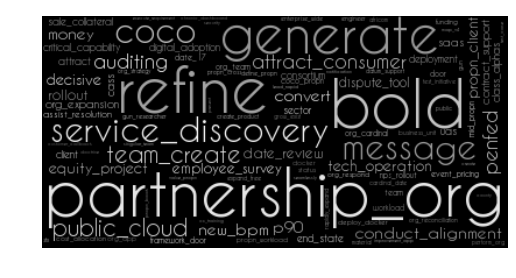

In [77]:
"""
===============
Generate word clouds of most common words and verbs per class:
"""
#class_1 = []
#for feature, coefficient in zip(top_feat['Class_1'].Feature,top_feat['Class_1'].Coefficient):
#    lists = [feature.replace(" ", "_")]*(100+int(round(coefficient*100)))
#    class_1 = class_1+lists
% matplotlib inline

class_1 = []
for feature, coefficient in zip(top_feat['Class_3'].Feature,top_feat['Class_3'].Coefficient):
    lists = [feature.replace(" ", "_")]*(100+int(round(coefficient*100)))
    class_1 = class_1+lists


    
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

text = ' '.join(class_1)

# Generate a word cloud image
#wordcloud = WordCloud().generate(text)
wordcloud = WordCloud(font_path='CaviarDreams.ttf').generate(text)
# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
#plt.imshow(wordcloud)
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3))
plt.axis("off")

# lower max_font_size
#wordcloud = WordCloud(max_font_size=40).generate(text)
#plt.figure()
#plt.imshow(wordcloud)
#plt.axis("off")
#plt.show()

In [101]:
#Feature finder!
#data_text.loc[(data_text.loc[:,'BoW'].str.contains(top_feat['Class_4'].loc[10,'Feature'])==True),'X']
data_text.loc[(data_text.loc[:,'BoW'].str.contains('message')==True),['X','Y','BoW']]

,X,Y,BoW


# Model 2: syntactic features

## Functions and definitions:

Talk a lot about why and how you did this!

In [129]:
# Extract all syntactic components from text and return a dictionary:
def syntaxFeat(text):
    # get rid of newlines, and non alpha-numeric characters
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = re.sub(r'([^\s\w]|_)+', ' ', text)
    text = text.replace(' +',' ')


    # parse it
    parsed_text = nlp(text)
    
    # get tokens, and length
    token_parsed = [token for token in parsed_text]
    len_token = len(token_parsed)
    
    # Walk up the syntactic tree, collecting the arc labels.
    len_dep = []
    for token in token_parsed:
        dep_labels = []
        while token.head is not token:
            dep_labels.append(token.dep_)
            token = token.head
        len_dep.append(len(dep_labels))
    #this is the longest subtree, one variable you need to return
    max_stree = max(len_dep)
    
    #count entities/length of sentence
    perc_ents = len(parsed_text.ents)/len_token
    
    #count proper nouns
    perc_propn = sum([token.pos_=='PROPN' for token in parsed_text])/len_token
    
    #count noun chunks
    perc_nounch = len([token for token in parsed_text.noun_chunks])/len_token
    
    #count words out of vocabulary
    perc_oov = sum([token.is_oov for token in parsed_text])/len_token
    
    #count numbers
    perc_num = sum([token.like_num for token in parsed_text])/len_token
    
    return {'len_token':len_token,'max_stree':max_stree,'perc_ents':perc_ents,'perc_propn':perc_propn,
            'perc_nounch':perc_nounch,'perc_oov':perc_oov,'perc_num':perc_num}

In [130]:
#Do syntax features for every row and return a dataframe
def syntaxFeatures(df):    
    syntax = pd.DataFrame()
    for i in df.index.values:
        temp = syntaxFeat(df.loc[i,'X'])
        syntax = syntax.append(temp,ignore_index=True)
    return syntax

## Fit

In [131]:
X_syntax = preprocessing.normalize(syntaxFeatures(data_text))

In [132]:
train, test, labels_train, labels_test = train_test_split(X_syntax,data_text['Y'], test_size=0.20, random_state=42)

In [133]:
clf_syn = DecisionTreeClassifier(max_depth=5)

In [134]:
clf_syn.fit(train,labels_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [135]:
preds_syn = clf_syn.predict(test)

In [136]:
print("----------------------------------------------------------------------------------------------")
print("Accuracy score: ",accuracy_score(labels_test, preds_syn))

----------------------------------------------------------------------------------------------
Accuracy score:  0.496172581768


In [137]:
print("----------------------------------------------------------------------------------------------")
print("classification report: ",classification_report(labels_test, preds_syn))

----------------------------------------------------------------------------------------------
classification report:               precision    recall  f1-score   support

          1       0.57      0.66      0.61       562
          2       0.43      0.67      0.53       498
          3       0.00      0.00      0.00       204
          4       1.00      0.02      0.05       173

avg / total       0.49      0.50      0.43      1437



## Store predictions of model 2

In [138]:
Syn_predict = clf_syn.predict(X_syntax)

# Model 3: Psyco-linguistics

## Functions

In [139]:
#Get all the vocabulary in the corpus and its features:
def vocab_pl(data):
    #get dictionary data
    pl_data = pd.read_csv('pl_dict_clean.csv')
    pl_data = pl_data[['word','fam','conc','imag','kf_wf']]
    pl_data = pl_data.dropna(thresh=2).drop_duplicates()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        pl_data = pl_data.groupby('word').agg({'fam': np.nanmean,'conc': np.nanmean,'imag': np.nanmean, 
                                               'kf_wf':np.nanmean}).reset_index() 

    vocab = []
    for i in data.index.values:
        # get rid of newlines, and non alpha-numeric characters
        text = data.loc[i,'X']
        text = text.strip().replace("\n", " ").replace("\r", " ")
        text = re.sub(r'([^\s\w]|_)+', ' ', text)
        text = text.replace(' +',' ')
        parsed_text = nlp(text)
        token_text = [token.orth_ for token in parsed_text]
        for token in token_text:
            vocab.append(token.upper())
    vocab = list(set(vocab))
    
    vocab_in_pl = [word for word in vocab if word in list(pl_data.word)]
    pl_data =  pl_data[pl_data['word'].isin(vocab_in_pl)]
    
    return pl_data


In [140]:
# Score each sentence
def pl_features(text,pl_data):
        
    # get rid of newlines, and non alpha-numeric characters
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = re.sub(r'([^\s\w]|_)+', ' ', text)
    text = text.replace(' +',' ')

    # parse it
    parsed_text = nlp(text)
    
    # get tokens
    token_text = [token.orth_ for token in parsed_text]

    kf_scores = []
    fam_scores = []
    conc_scores = []
    imag_scores = []
    for token in token_text:
        kf_scores.append(pl_data.loc[pl_data['word']==token.upper(),'kf_wf'].max())
        fam_scores.append(pl_data.loc[pl_data['word']==token.upper(),'fam'].max())
        conc_scores.append(pl_data.loc[pl_data['word']==token.upper(),'conc'].max())
        imag_scores.append(pl_data.loc[pl_data['word']==token.upper(),'imag'].max())
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        kf =   np.nanmean(kf_scores)
        fam =  np.nanmean(fam_scores)
        conc = np.nanmean(conc_scores)
        imag = np.nanmean(imag_scores)
        perc_kf = 1-(np.isnan(kf_scores).sum()/len(kf_scores))
    
    return {'kf_score': kf,'fam_score': fam,'conc_score': conc,'imag_score': imag,'perc_kf': perc_kf}


In [141]:
#Run it for all the dataset:
def plFeatures(df,pl_data):
    #get dictionary data
#    pl_data = vocab_pl(df)

    pl = pd.DataFrame()
    for i in df.index.values:
        temp = pl_features(df.loc[i,'X'],pl_data)
        pl = pl.append(temp,ignore_index=True)
    return pl


In [143]:
#Get data from psycolinguistic dictionary
pl_data = vocab_pl(data_text)

In [144]:
X_pl = plFeatures(data_text,pl_data)
X_pl = preprocessing.normalize(X_pl.fillna(X_pl.mean()))

In [ ]:
#X_pl = X_pl.fillna(X_pl.mean())

In [ ]:
clf_pl =  AdaBoostClassifier()

In [ ]:
train, test, labels_train, labels_test = train_test_split(X_pl,data_text['Y'], test_size=0.20, random_state=42)

In [ ]:
clf_pl.fit(train,labels_train)

In [ ]:
preds_pl = clf_pl.predict(test)

In [ ]:
print("----------------------------------------------------------------------------------------------")
print("Accuracy score: ",accuracy_score(labels_test, preds_pl))

In [ ]:
print("----------------------------------------------------------------------------------------------")
print("classification report: ",classification_report(labels_test, preds_pl))

In [ ]:
Pl_predict = clf_pl.predict(X_pl)

# Model 4: non-text

In [233]:
train, test, labels_train, labels_test = train_test_split(data_feat.drop('Y',axis=1),
                                                        data_feat['Y'].astype(int), test_size=0.20, random_state=42)

In [234]:
model_nt = m.LogisticIT()
model_nt = model_nt.fit(train, labels_train)
preds_nt = model_nt.predict(test)

In [235]:
print("----------------------------------------------------------------------------------------------")
print("Accuracy score: ",accuracy_score(labels_test, preds_nt))

----------------------------------------------------------------------------------------------
Accuracy score:  0.600556715379


In [236]:
print("----------------------------------------------------------------------------------------------")
print("classification report: ",classification_report(labels_test, preds_nt))

----------------------------------------------------------------------------------------------
classification report:               precision    recall  f1-score   support

          1       0.97      0.65      0.78       562
          2       0.48      0.97      0.64       498
          3       0.00      0.00      0.00       204
          4       0.29      0.07      0.11       173

avg / total       0.58      0.60      0.54      1437



/Users/marleneguraieb/anaconda2/envs/python3_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
Nt_predict = model_nt.predict(data_feat.drop('Y',axis=1))

## Model non-BoW

In [339]:
train, test, labels_train, labels_test = train_test_split(X_stacked.drop('BoW',axis=1),
                                                        data_feat['Y'].astype(int), test_size=0.20, random_state=42)

In [340]:
model_nb = m.LogisticIT()
model_nb = model_nb.fit(train, labels_train)
preds_nb = model_nb.predict(test)

In [341]:
print("----------------------------------------------------------------------------------------------")
print("Accuracy score: ",accuracy_score(labels_test, preds_nt))

----------------------------------------------------------------------------------------------
Accuracy score:  0.600556715379


In [342]:
print("----------------------------------------------------------------------------------------------")
print("classification report: ",classification_report(labels_test, preds_nt))

----------------------------------------------------------------------------------------------
classification report:               precision    recall  f1-score   support

          1       0.97      0.65      0.78       562
          2       0.48      0.97      0.64       498
          3       0.00      0.00      0.00       204
          4       0.29      0.07      0.11       173

avg / total       0.58      0.60      0.54      1437



/Users/marleneguraieb/anaconda2/envs/python3_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Final model I:

In [145]:
X_stacked = pd.concat([pd.DataFrame(BoW_predict,columns=['BoW']),
                       pd.DataFrame(X_syntax),
                       pd.DataFrame(X_pl),
                       data_feat.drop('Y',axis=1).reset_index()], axis=1, join='inner')

In [146]:
train, test, labels_train, labels_test = train_test_split(X_stacked,data_text['Y'], test_size=0.20, random_state=42)

In [147]:
model_fin = KNeighborsClassifier(3)
model_fin = model_fin.fit(train, labels_train)

In [148]:
predict = model_fin.predict(test)
print("accuracy:", accuracy_score(labels_test, predict))

accuracy: 0.76965901183


In [149]:
print("----------------------------------------------------------------------------------------------")
print("classification report: ",classification_report(labels_test, predict))

----------------------------------------------------------------------------------------------
classification report:               precision    recall  f1-score   support

          1       0.86      0.94      0.90       562
          2       0.78      0.86      0.82       498
          3       0.53      0.40      0.46       204
          4       0.56      0.40      0.46       173

avg / total       0.75      0.77      0.76      1437



In [151]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.94  0.03  0.02  0.01]
 [ 0.07  0.86  0.04  0.03]
 [ 0.12  0.3   0.4   0.18]
 [ 0.15  0.24  0.21  0.4 ]]


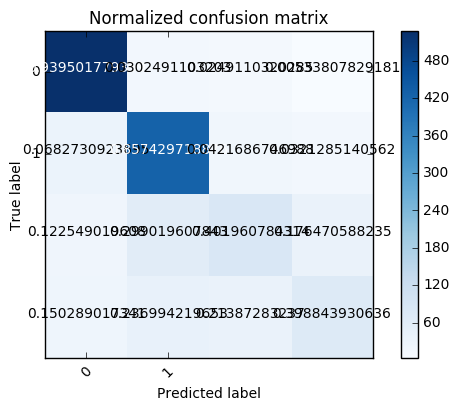

In [152]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(labels_test, predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=[0,1],
#title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [221]:
list(top_feat['Class_1'].Coefficient)

[-0.15277408103505147,
 -0.33212581091065446,
 -0.29050428901420966,
 -0.32488165644048961,
 -0.20375608765884859,
 -0.66780576971839067,
 -0.32869607106174142,
 -0.67895773900895473,
 -0.17346781172323866,
 -0.18357273958704692]

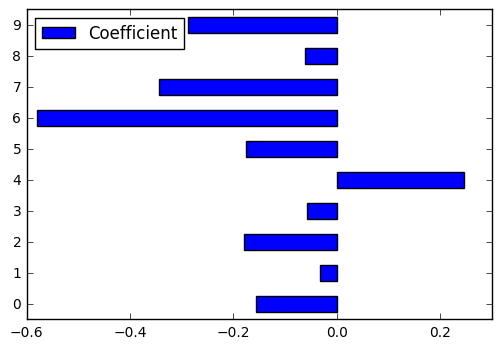

In [233]:
% matplotlib inline
top_feat['Class_4'].plot.barh(stacked=True);

In [141]:
from PIL import Image
from os import path


(-0.5, 399.5, 199.5, -0.5)

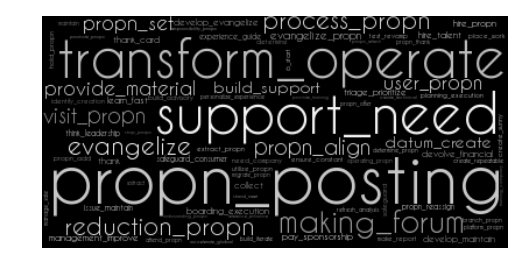

In [193]:
"""
===============
Generate word clouds of most common words and verbs per class:
"""
#class_1 = []
#for feature, coefficient in zip(top_feat['Class_1'].Feature,top_feat['Class_1'].Coefficient):
#    lists = [feature.replace(" ", "_")]*(100+int(round(coefficient*100)))
#    class_1 = class_1+lists

class_1 = []
for feature, coefficient in zip(top_verb['Class_4'].Verb,top_feat['Class_1'].Coefficient):
    lists = [feature.replace(" ", "_")]*(100+int(round(coefficient*100)))
    class_1 = class_1+lists


    
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

text = ' '.join(class_1)

# Generate a word cloud image
#wordcloud = WordCloud().generate(text)
wordcloud = WordCloud(font_path='CaviarDreams.ttf').generate(text)
# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
#plt.imshow(wordcloud)
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3))
plt.axis("off")

# lower max_font_size
#wordcloud = WordCloud(max_font_size=40).generate(text)
#plt.figure()
#plt.imshow(wordcloud)
#plt.axis("off")
#plt.show()

In [105]:
data_text

,X,Y,BoW
0,Support the robust pipeline of top-tier talent and participate in the applicant candidate process.,4,support the robust pipeline of top tier talent and participate in the applicant candidate process
1,Clarify the CrossLead and McChrystal brand relationships and messaging.,3,clarify the propn and propn brand relationships and messaging
2,Copy: IPR: CS (Product & Requirements),1,propn propn propn propn requirements
3,"Attract, assess, develop, organize and retain best-in-class product development talent",3,propn assess develop organize and retain best in class product development talent
4,"Attract, assess, develop X X personnel for Team Discovery’s expanded charter (Disco + Decision...",1,propn assess develop x x personnel for propn propn s expanded charter propn propn
5,F1.2 - Implement and maintain ERP and reporting systems / processes to manage and protect MG's...,3,f1 cardinal propn and maintain propn and reporting systems processes to manage and protect propn s
6,"**CLIENTS**\nBranded Card aligned and ready to engage in the design, build, and implementation of...\n\n...",1,propn propn propn aligned and ready to engage in the design build and implementation of
7,"Align all fundamental touchpoints to the brand, ensuring consistency and enhancing the impact of...",3,align all fundamental touchpoints to the brand ensuring consistency and enhancing the impact of
8,**FINANCIALS**\nREVENUE: Jan-Apr: $270K (+ expenses); May-Sep: $1.7M (+ expenses); Oct-? $1.03M (+...\n...\n...,1,financials revenue propn propn 270k expenses propn ay propn 1 7 propn expenses propn 1 03 propn
9,Sustain post-book launch momentum to support cultivation of CrossLead belief system,1,sustain post book launch momentum to support cultivation of propn belief system


In [ ]:
data_text.Y.value_counts()/data_text.shape[0]